# Module 1 Final Project

* Student name: Vadym Byesyedin
* Student pace: self paced
* Scheduled project review date/time: 07/08/2020 11:00 am
* Instructor name: Jeff Herman
* Blog post URL: https://medium.com/@vadym.byesyedin/selecting-the-best-director-with-help-of-the-data-science-16b4f3d8ef3

#### Load libraries


In [228]:
import sqlite3
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

#### Establish connection

In [365]:
conn = sqlite3.connect("movie.sqlite")
cur = conn.cursor()

List tables

In [366]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()

[('tmdb_movies',),
 ('tn_movie_budgets',),
 ('imdb_title_basics',),
 ('imdb_name_basics',),
 ('imdb_title_principals',)]

Ensure that 'director' value of 'category' column is what is needed

In [133]:
temp_df = pd.DataFrame(cur.execute("SELECT * FROM imdb_title_principals;").fetchall())
temp_df.columns = [i[0] for i in cur.description]
temp_df.category.unique()

array(['actor', 'director', 'producer', 'editor', 'actress', 'composer',
       'cinematographer', 'writer', 'self', 'production_designer',
       'archive_footage', 'archive_sound'], dtype=object)

## Q1: Best director by profit and popularity?
### Best director by their films popularity

In [186]:
cur.execute('''SELECT m.original_title, m.popularity, n.primary_name AS director 
               FROM tmdb_movies AS m 
               JOIN imdb_title_basics AS t USING(original_title) 
               JOIN imdb_title_principals AS p USING(tconst)
               JOIN imdb_name_basics AS n USING(nconst) 
               WHERE p.category = 'director' 
               ORDER BY m.popularity DESC
               ''')

q11_df = pd.DataFrame(cur.fetchall())
q11_df.columns = [i[0] for i in cur.description]

#### Top directors by their most popular film

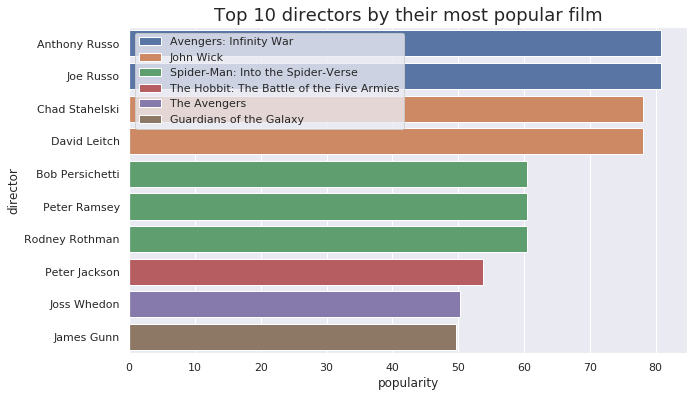

In [297]:
q11_df_sorted = q11_df.sort_values(by=['popularity'], ascending=False)

plt.figure(figsize=(10,6))
q11_df_sorted_chart = sns.barplot(
    x="popularity", 
    y="director", 
    hue="original_title", 
    orient="h", 
    dodge=False,
    data=q11_df_sorted.head(10))
q11_df_sorted_chart.set_title('Top 10 directors by their most popular film',fontsize=18)
q11_df_sorted_chart.legend(loc='upper left');

#### Top directors by their film popularity mean

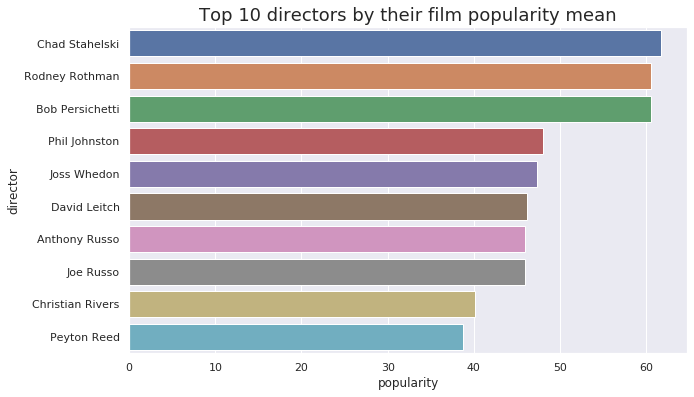

In [286]:
mean1_df = q11_df.groupby('director').mean()
mean1_df['films_count'] = q11_df.groupby('director').size()
mean1_df_sorted = mean1_df.sort_values(by=['popularity'], ascending=False)

# flatten df for plot
mean1_df_sorted.reset_index(inplace=True)
plt.figure(figsize=(10,6))
mean1_df_sorted_chart = sns.barplot(x="popularity", y="director", orient="h", data=mean1_df_sorted.head(10))
mean1_df_sorted_chart.set_title('Top 10 directors by their film popularity mean',fontsize=18);

But low number of observations should be taken into account<br>
Most directors made 1 or 2 films<br>
<br>
Film popularity distribution grouped by number of director films

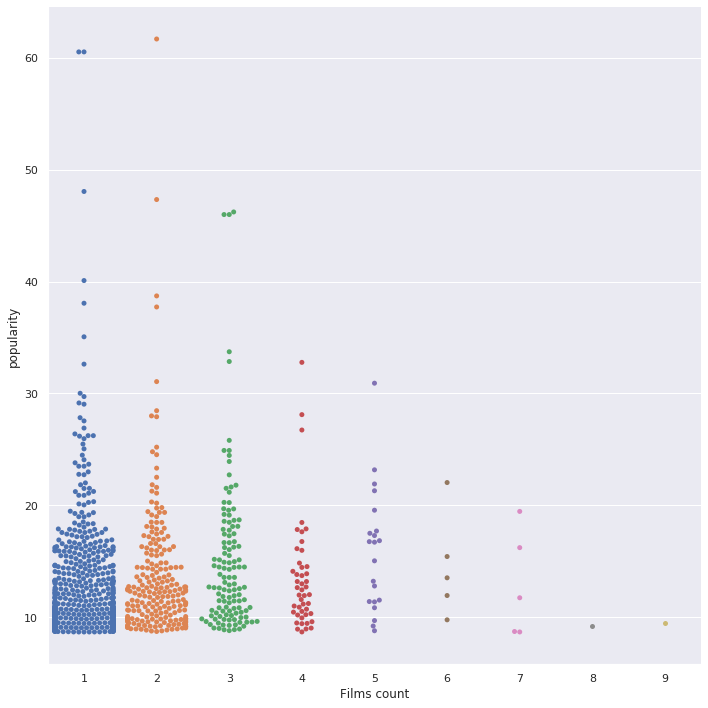

In [472]:
mean1_df_sorted_catplot = sns.catplot(
    x="films_count", 
    y="popularity", 
    kind="swarm", 
    height=10, 
    data=mean1_df_sorted.head(1000))
mean1_df_sorted_catplot.set_xlabels('Films count');

### Best director by profit

In [283]:
cur.execute('''SELECT   b.movie, 
                        (b.worldwide_gross - b.production_budget) AS profit, 
                        n.primary_name AS director 
               FROM tn_movie_budgets AS b 
               JOIN imdb_title_basics AS t on t.primary_title=b.movie 
               JOIN imdb_title_principals AS p USING(tconst)
               JOIN imdb_name_basics AS n USING(nconst) 
               WHERE p.category = 'director' 
               ORDER BY profit DESC
               ''')

q12_df = pd.DataFrame(cur.fetchall())
q12_df.columns = [i[0] for i in cur.description]
#q12_df.head(10)

### Top directors by their most profitable film

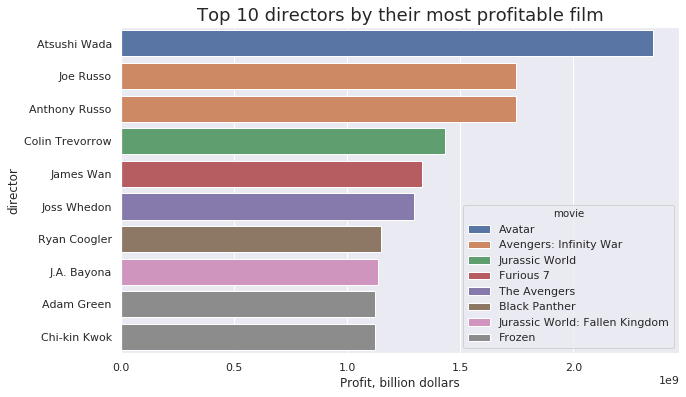

In [285]:
q12_df_sorted = q12_df.sort_values(by=['profit'], ascending=False)

plt.figure(figsize=(10,6))
q12_df_sorted_chart = sns.barplot(
    x="profit", 
    y="director", 
    hue="movie", 
    orient="h", 
    dodge=False, 
    data=q12_df_sorted.head(10))
q12_df_sorted_chart.set_title('Top 10 directors by their most profitable film',fontsize=18);
q12_df_sorted_chart.set_xlabel('Profit, billion dollars');

### Top directors by their film profit mean

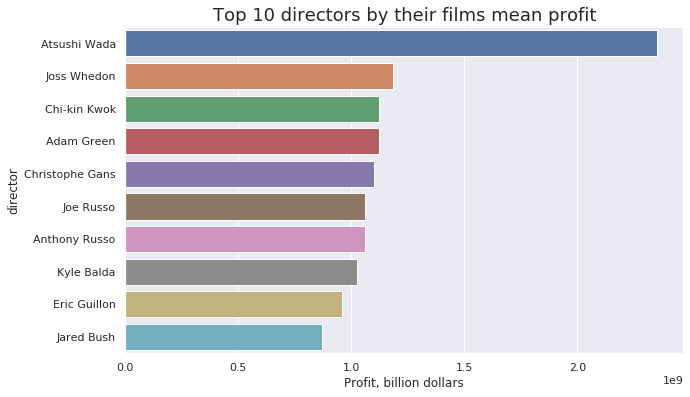

In [473]:
mean2_df = q12_df.groupby('director').mean()
mean2_df['films_count'] = q12_df.groupby('director').size()
mean2_df_sorted = mean2_df.sort_values(by=['profit'], ascending=False)

# flatten df for plot
mean2_df_sorted.reset_index(inplace=True)
plt.figure(figsize=(10,6))
mean2_df_sorted_chart = sns.barplot(x="profit", y="director", orient="h", data=mean2_df_sorted.head(10))
mean2_df_sorted_chart.set_title('Top 10 directors by their films mean profit',fontsize=18)
mean2_df_sorted_chart.set_xlabel('Profit, billion dollars');

## Q2: Most popular genre by year and overall?

In [441]:
cur.execute('''SELECT m.original_title AS title, t.start_year AS year, t.genres 
               FROM tmdb_movies AS m 
               JOIN imdb_title_basics AS t USING(original_title)
               WHERE year <= strftime('%Y', CURRENT_TIMESTAMP)
               ''')

q2_df = pd.DataFrame(cur.fetchall())
q2_df.columns = [i[0] for i in cur.description]
#q2_df.head()

In [442]:
genres_df = pd.DataFrame(q2_df['genres'].str.split(",", expand = True))
# create list of unique genres
unique_genres_list = list(set().union(genres_df[0], genres_df[1], genres_df[2]))
unique_genres_list.remove(None)

def check_str(substr, string):
    if substr in string:
        return 1
    else:
        return 0


q2_df_splitted_genres = q2_df[['year','genres']]
for genre in unique_genres_list:
    q2_df_splitted_genres[genre] = q2_df['genres'].apply(lambda genres: check_str(genre,genres))
    
#q2_df_splitted_genres.head()

q2_df_splitted_genres.drop(columns=['genres'], inplace=True)

q2_df_splitted_genres_grouped_by_year = q2_df_splitted_genres.groupby('year').sum()
q2_df_splitted_genres_grouped_by_year

,Adventure,Reality-TV,Horror,Romance,Sci-Fi,Fantasy,Musical,Game-Show,Talk-Show,Drama,...,Crime,Thriller,Western,Sport,Action,Comedy,Animation,History,War,Short
year,,,,,,,,,,,,,,,,,,,,,
2010.0,95,1,211,178,68,50,17,0,0,700,...,146,251,10,33,190,388,31,45,19,0
2011.0,99,0,254,190,80,59,17,0,1,749,...,138,270,16,38,184,420,33,58,21,1
2012.0,120,0,298,157,85,56,18,0,0,748,...,157,298,11,28,199,431,44,71,21,0
2013.0,163,0,339,209,119,77,11,0,0,898,...,166,367,9,47,234,457,40,89,16,0
2014.0,158,1,357,212,105,75,18,0,0,891,...,195,384,17,46,236,495,51,89,22,0
2015.0,141,0,365,178,114,63,11,0,0,908,...,172,341,10,46,220,456,38,67,28,0
2016.0,165,1,363,153,101,81,14,1,0,886,...,189,352,10,43,271,438,45,67,19,0
2017.0,142,0,360,153,115,70,20,0,0,847,...,168,349,16,35,217,387,44,62,28,0
2018.0,127,1,303,136,100,72,14,0,0,695,...,156,328,16,32,224,338,38,33,15,1


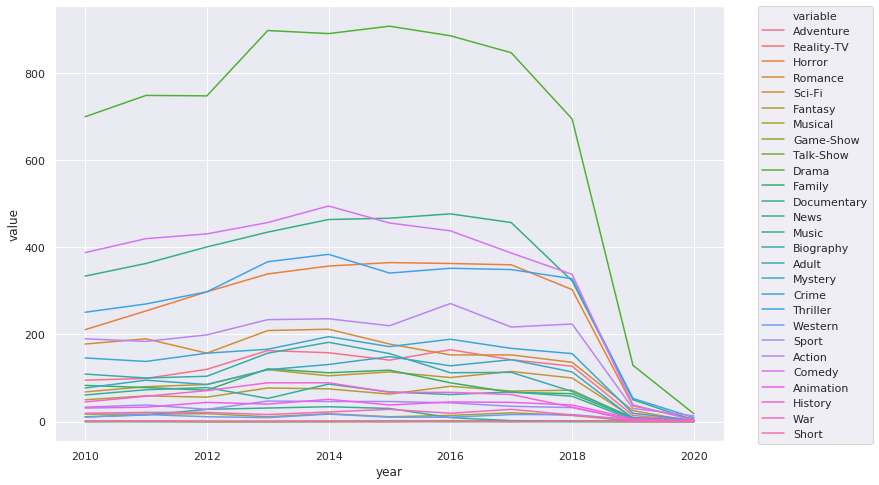

In [443]:
plt.figure(figsize=(12,8))
sns.lineplot(x='year', y='value', hue='variable', 
    data=pd.melt(q2_df_splitted_genres_grouped_by_year.reset_index(), ['year']))
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [450]:
q2_df_splitted_genres_grouped_by_year.idxmax(axis=1)

year
2010.0    Drama
2011.0    Drama
2012.0    Drama
2013.0    Drama
2014.0    Drama
2015.0    Drama
2016.0    Drama
2017.0    Drama
2018.0    Drama
2019.0    Drama
2020.0    Drama
dtype: object

In [457]:
q2_genres_max = q2_df_splitted_genres_grouped_by_year.max()
print('Maximum value in each column: ')
q2_genres_max_sorted = q2_genres_max.sort_values(ascending=False)
q2_genres_max_sorted

Maximum value in each column: 


Drama          908
Comedy         495
Documentary    477
Thriller       384
Horror         365
Action         271
Romance        212
Crime          195
Biography      182
Adventure      165
Mystery        149
Family         121
Sci-Fi         119
History         89
Music           86
Fantasy         81
Animation       51
Sport           47
News            34
War             28
Musical         20
Western         17
Adult            1
Talk-Show        1
Game-Show        1
Reality-TV       1
Short            1
dtype: int64

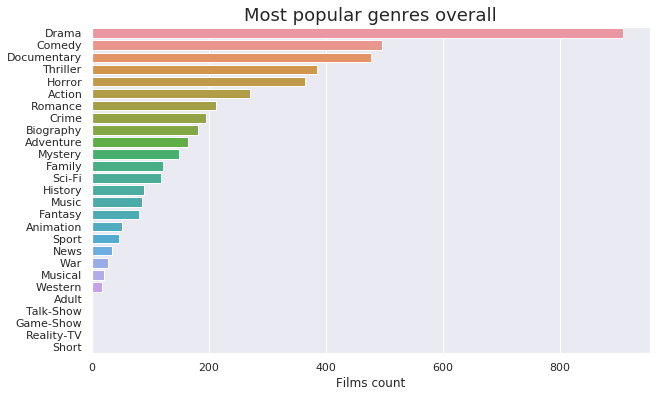

In [462]:
plt.figure(figsize=(10,6))
q2_genres_max_sorted_chart = sns.barplot(
    x=q2_genres_max_sorted, 
    y=q2_genres_max_sorted.index, 
    orient="h")

q2_genres_max_sorted_chart.set_title('Most popular genres overall',fontsize=18)
q2_genres_max_sorted_chart.set_xlabel('Films count');

## Q3: Best month to release the movie

In [355]:
cur.execute('''SELECT b.movie AS title, (b.worldwide_gross - b.production_budget) AS profit, t.release_date 
               FROM tn_movie_budgets AS b 
               JOIN tmdb_movies AS t on t.title=b.movie 
               ''')

q3_df = pd.DataFrame(cur.fetchall())
q3_df.columns = [i[0] for i in cur.description]
#q3_df.head()

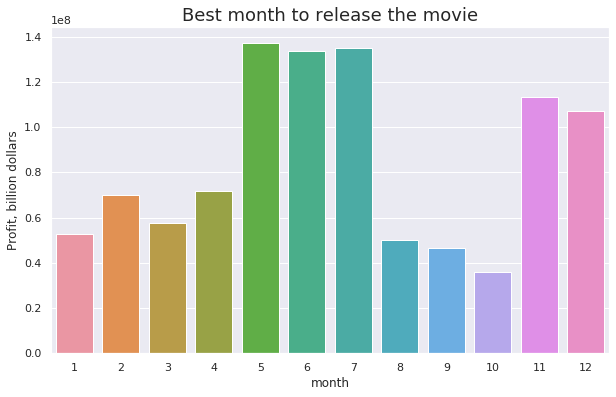

In [358]:
# create month column from release_date
q3_df['month'] = q3_df['release_date'].map(lambda x: int(x[5:7]) )
q3_grouped_df = q3_df.groupby('month').mean()
# suppress scientific notation
q3_grouped_df['profit'] = q3_grouped_df['profit'].round()

# flatten df for plot
q3_grouped_df.reset_index(inplace=True)
plt.figure(figsize=(10,6))
q3_grouped_df_chart = sns.barplot(x="month", y="profit", data=q3_grouped_df)
q3_grouped_df_chart.set_title('Best month to release the movie',fontsize=18)
q3_grouped_df_chart.set_ylabel('Profit, billion dollars');